In [7]:
import numpy as np
import torch
import os
import pickle
import time
from Model import *
from itertools import chain
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from synthetic import simulate_lorenz_96, simulate_var
from utils import build_flags, time_split, save_result, evaluate_result, count_accuracy, loss_sparsity, loss_divergence, loss_mmd
from IPython.display import clear_output

In [2]:
parser = build_flags()
args = parser.parse_args(args=[])
args.seed = 2
args.num_nodes = 264
args.dims = 1
args.threshold = 0.5
args.time_length = 500
args.time_step = 10
args.epochs = 3000
args.batch_size = 128
args.lr = 1e-3
args.weight_decay = 1e-3
args.encoder_alpha = 0.02
args.decoder_alpha = 0.02
args.beta_sparsity = 3.00 #0.25   #log_sum  #1.25是F=40,N=30的最优值
args.beta_kl = 0.01        #JS散度
args.beta_mmd = 2      #MMD
args.encoder_hidden = 20
args.decoder_hidden = 20
args.encoder_dropout = 0.1
args.decoder_dropout = 0.2

In [3]:
sample = np.load('/home/xuzijian/crf/Intrer_VAE/PNC_SPM_emoid4.npy')
samples = []
for i in range(0, 207, 9):
    group = sample[:, :, i:i+9]
    samples.append(group)
samples.append(sample[:, :, 201:210])

In [4]:
print(sample.shape)

(204, 264, 210)


In [ ]:
print(len(samples))
#两个部分是相等的
print(samples[22][:,:, 3:9])
print(samples[23][:,:, 0:6])   #到时候选择的时候，直接就是samples[23][:,:,6:9]就行了


In [5]:
init_adj = np.load('/home/xuzijian/crf/Intrer_VAE/init_adj_emoid4.npy')
init_adj = torch.tensor(init_adj)

In [5]:
# causality_matrix = []
for idx in range(264):
    # encoder_file = 'encoder' + str(idx) + '.pt'
    # encoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/DLCR_PNC_emoid1', encoder_file)
    # encoder_file = '/home/xuzijian/crf/Intrer_VAE_result/help_100/encoder0.pt'
    mask_list = []
    for data in samples:
        data = data[:,:,:,np.newaxis]
        data = torch.FloatTensor(data)
        est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
        est_net.load_state_dict(torch.load(encoder_file, map_location='cuda:0'))
        # est_net = est_net.cuda()
        est_net.eval()
        inputs = data#X_np[:, :, :-1, :]#.cuda()   #:-1和1:有什么区别
        mu, log_var = est_net(inputs)
        # mu = mu.cpu().detach()
        # log_var = log_var.cpu().detach()
        sigma = torch.exp(log_var / 2)
        # sigma2 = torch.exp(log_var2 / 2)
        gamma = torch.randn(size = mu.size())
        # theta = torch.randn(size = mu1.size())
        gamma = mu + sigma * gamma
        # theta = mu2 + sigma2* theta
        mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
        mask_matrix = mask_matrix.squeeze()
        mask_list.append(mask_matrix)
    mask_list[23] = mask_list[23][:, :, 6:9]
    mask_list = torch.cat(mask_list, dim = 2)
    # causality_matrix.append(mask_list)
    save_file = 'encoder_emoid' + str(idx) + '.npy'
    save_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid4', save_file)
    # np.save(save_file, mask_list.detach().numpy())
    clear_output()
# causality_matrix = torch.stack(causality_matrix, dim = 2)
# np.save('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid1/encoder_emoid1.npy', causality_matrix.detach().numpy())



In [6]:
print(mask_list.shape)
cc = mask_list.mean(dim=2).mean(dim=0)
print(sum(cc > 0.5))

torch.Size([222, 264, 210])
tensor(72)


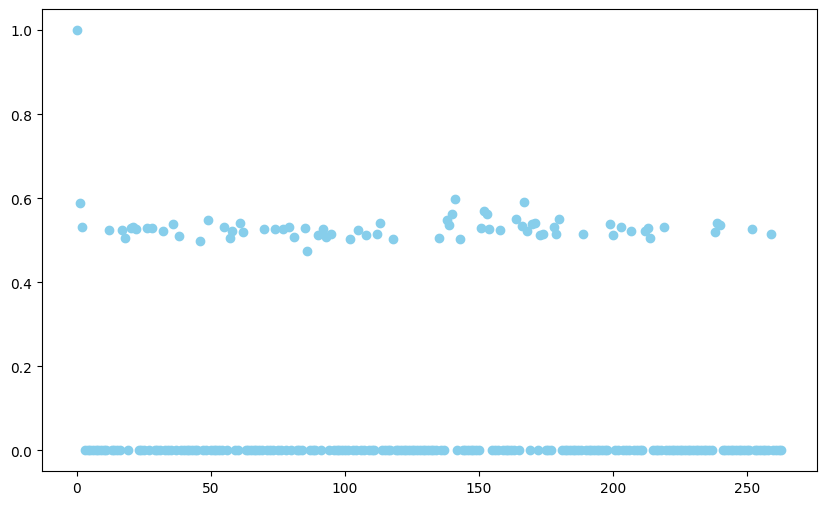

In [7]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  cc.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [11]:
# causality_matrix = []
for idx in range(1):
    # encoder_file = 'encoder' + str(idx) + '.pt'
    # encoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/DLCR_PNC_emoid1', encoder_file)
    encoder_file = '/home/xuzijian/crf/Intrer_VAE_result/help_10/encoder0.pt'
    mask_list = []
    for data in samples:
        data = data[:,:,:,np.newaxis]
        data = torch.FloatTensor(data)
        est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
        est_net.load_state_dict(torch.load(encoder_file, map_location='cuda:0'))
        # est_net = est_net.cuda()
        est_net.eval()
        inputs = data#X_np[:, :, :-1, :]#.cuda()   #:-1和1:有什么区别
        mu, log_var = est_net(inputs)
        # mu = mu.cpu().detach()
        # log_var = log_var.cpu().detach()
        sigma = torch.exp(log_var / 2)
        # sigma2 = torch.exp(log_var2 / 2)
        gamma = torch.randn(size = mu.size())
        # theta = torch.randn(size = mu1.size())
        gamma = mu + sigma * gamma
        # theta = mu2 + sigma2* theta
        mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
        mask_matrix = mask_matrix.squeeze()
        mask_list.append(mask_matrix)
    mask_list[23] = mask_list[23][:, :, 6:9]
    mask_list = torch.cat(mask_list, dim = 2)
    # causality_matrix.append(mask_list)
    save_file = 'encoder_emoid' + str(idx) + '.npy'
    save_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid4', save_file)
    # np.save(save_file, mask_list.detach().numpy())
    clear_output()
# causality_matrix = torch.stack(causality_matrix, dim = 2)
# np.save('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid1/encoder_emoid1.npy', causality_matrix.detach().numpy())

In [12]:
print(mask_list.shape)
cc = mask_list.mean(dim=2).mean(dim=0)
print(sum(cc > 0.1))

torch.Size([222, 264, 210])
tensor(68)


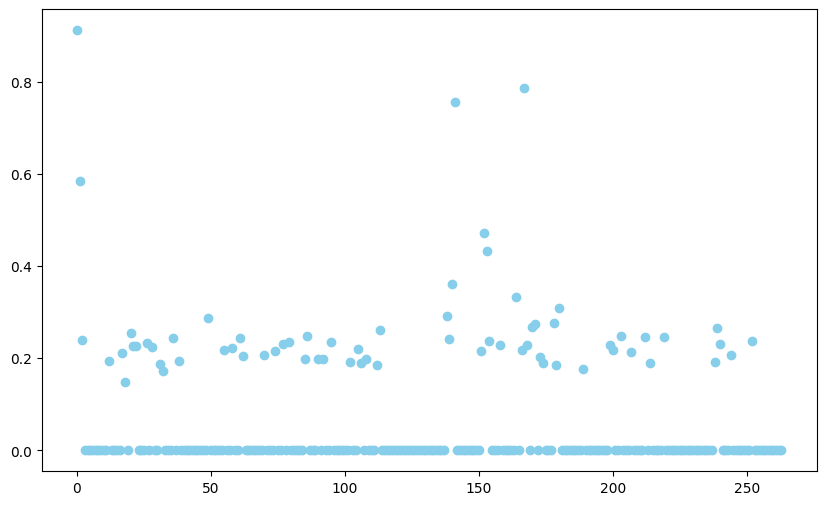

In [13]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  cc.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [5]:
# causality_matrix = []
for idx in range(1):
    # encoder_file = 'encoder' + str(idx) + '.pt'
    # encoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/DLCR_PNC_emoid1', encoder_file)
    encoder_file = '/home/xuzijian/crf/Intrer_VAE_result/help1_3/encoder0.pt'
    mask_list = []
    for data in samples:
        data = data[:,:,:,np.newaxis]
        data = torch.FloatTensor(data)
        est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
        est_net.load_state_dict(torch.load(encoder_file, map_location='cuda:0'))
        # est_net = est_net.cuda()
        est_net.eval()
        inputs = data#X_np[:, :, :-1, :]#.cuda()   #:-1和1:有什么区别
        mu, log_var = est_net(inputs)
        # mu = mu.cpu().detach()
        # log_var = log_var.cpu().detach()
        sigma = torch.exp(log_var / 2)
        # sigma2 = torch.exp(log_var2 / 2)
        gamma = torch.randn(size = mu.size())
        # theta = torch.randn(size = mu1.size())
        gamma = mu + sigma * gamma
        # theta = mu2 + sigma2* theta
        mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
        mask_matrix = mask_matrix.squeeze()
        mask_list.append(mask_matrix)
    mask_list[23] = mask_list[23][:, :, 6:9]
    mask_list = torch.cat(mask_list, dim = 2)
    # causality_matrix.append(mask_list)
    save_file = 'encoder_emoid' + str(idx) + '.npy'
    save_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid4', save_file)
    # np.save(save_file, mask_list.detach().numpy())
    clear_output()
# causality_matrix = torch.stack(causality_matrix, dim = 2)
# np.save('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid1/encoder_emoid1.npy', causality_matrix.detach().numpy())

In [11]:
print(mask_list.shape)
cc = mask_list.mean(dim=2).mean(dim=0)
print(sum(cc > 0.995))

torch.Size([222, 264, 210])
tensor(60)


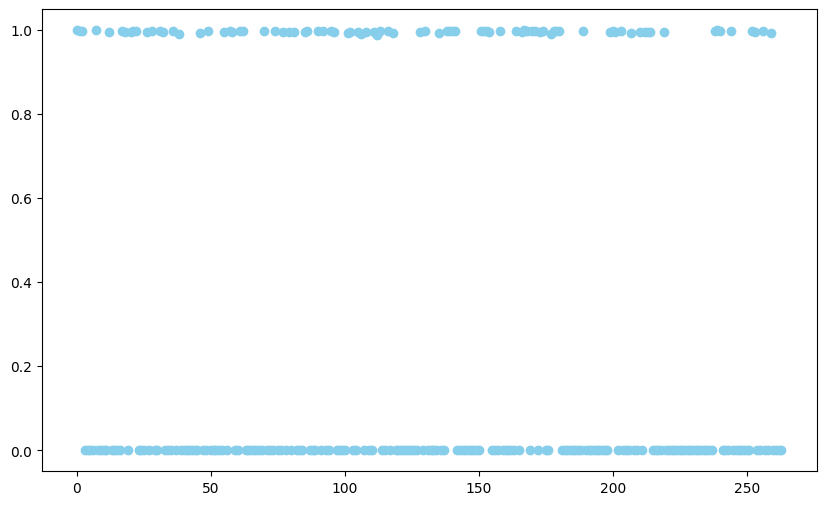

In [13]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  cc.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [5]:
# causality_matrix = []
for idx in range(264):
    encoder_file = 'encoder' + str(idx) + '.pt'
    encoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help1_7', encoder_file)
    # encoder_file = '/home/xuzijian/crf/Intrer_VAE_result/help_10/encoder3.pt'
    mask_list = []
    for data in samples:
        data = data[:,:,:,np.newaxis]
        data = torch.FloatTensor(data)
        est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
        est_net.load_state_dict(torch.load(encoder_file, map_location='cuda:1'))
        # est_net = est_net.cuda()
        est_net.eval()
        inputs = data#X_np[:, :, :-1, :]#.cuda()   #:-1和1:有什么区别
        mu, log_var = est_net(inputs)
        # mu = mu.cpu().detach()
        # log_var = log_var.cpu().detach()
        sigma = torch.exp(log_var / 2)
        # sigma2 = torch.exp(log_var2 / 2)
        gamma = torch.randn(size = mu.size())
        # theta = torch.randn(size = mu1.size())
        gamma = mu + sigma * gamma
        # theta = mu2 + sigma2* theta
        mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
        mask_matrix = mask_matrix.squeeze()
        mask_list.append(mask_matrix)
    mask_list[23] = mask_list[23][:, :, 6:9]
    mask_list = torch.cat(mask_list, dim = 2)
    # causality_matrix.append(mask_list)
    save_file = 'encoder_emoid' + str(idx) + '.npy'
    save_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help1_7', save_file)
    np.save(save_file, mask_list.detach().numpy())
    clear_output()
# causality_matrix = torch.stack(causality_matrix, dim = 2)
# np.save('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid1/encoder_emoid1.npy', causality_matrix.detach().numpy())

In [22]:
try_matrix = []
for idx in range(5):
    read_file = 'encoder_emoid' + str(idx) + '.npy'
    read_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help1_7', read_file)
    mask = np.load(read_file)
    try_matrix.append(mask)


print(len(try_matrix))

5


In [23]:
result = 0
for i in try_matrix:
    cc = i.mean(axis=2).mean(axis=0)
    result += sum(cc > 0.5)

print(result)

137


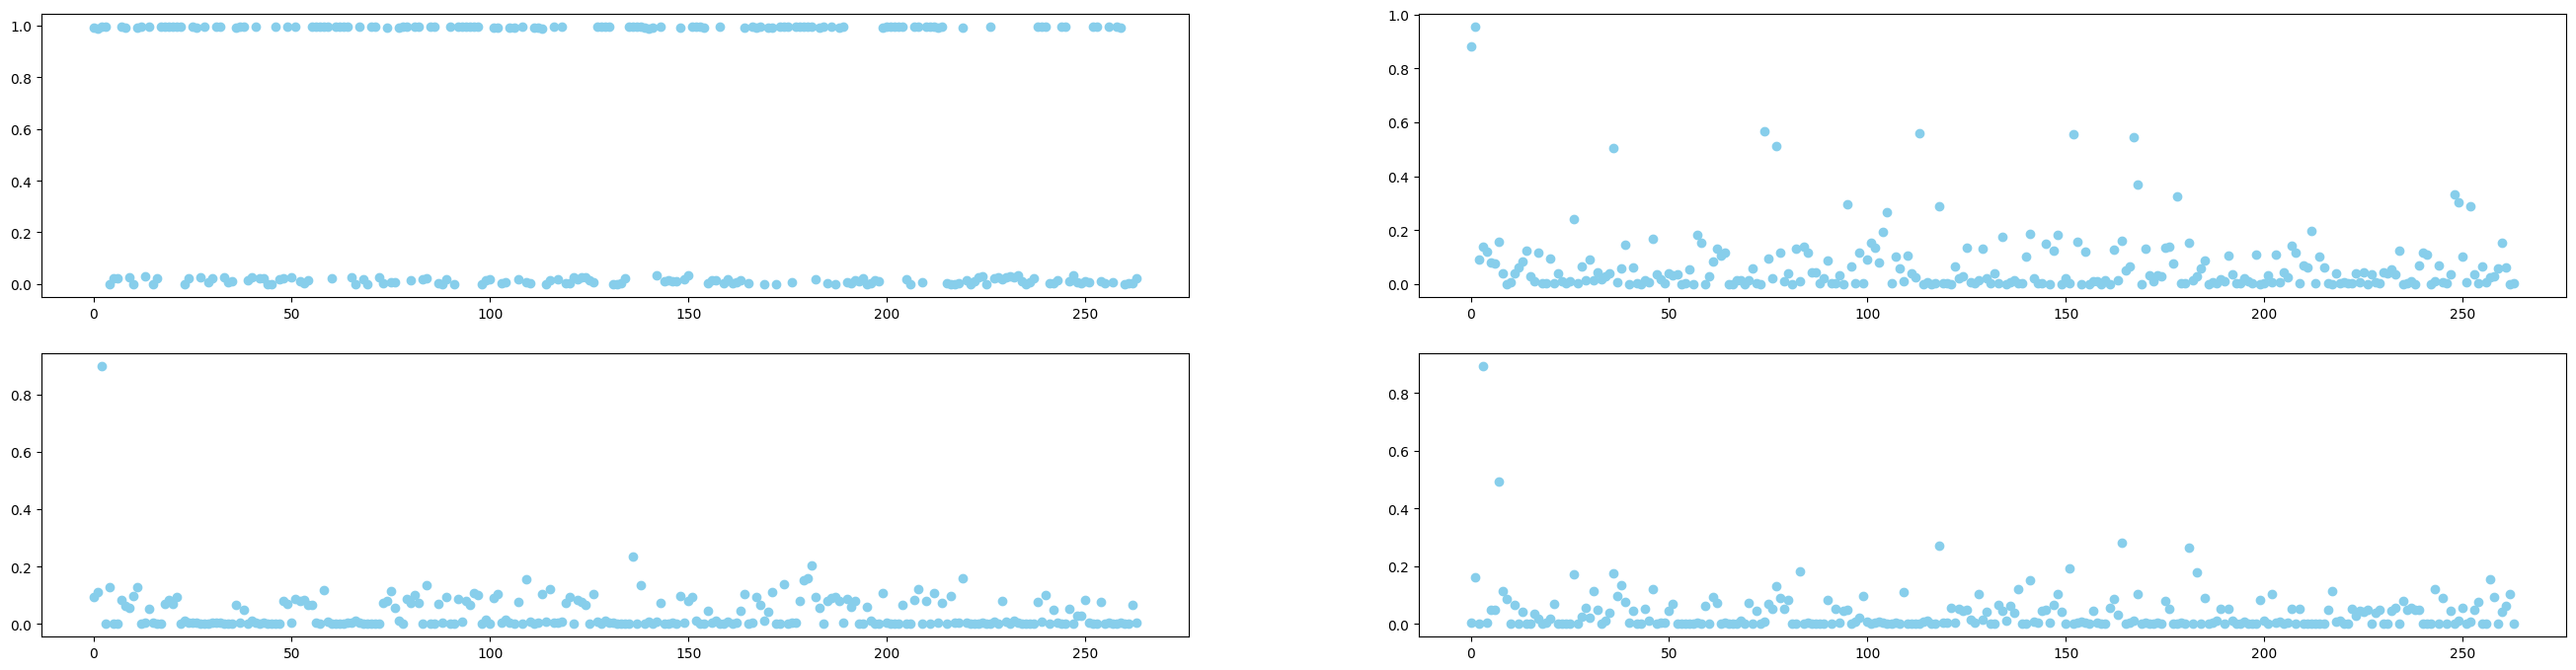

In [24]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(33, 8.2))  # 设置图形大小
fig1 = plt.subplot(2, 2, 1)
plt.scatter(range(264),  try_matrix[0].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig2 = plt.subplot(2, 2, 2)
plt.scatter(range(264),  try_matrix[1].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig3 = plt.subplot(2, 2, 3)
plt.scatter(range(264),  try_matrix[2].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig4 = plt.subplot(2, 2, 4)
plt.scatter(range(264),  try_matrix[3].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig5 = plt.subplot(2, 4, 5)
# plt.scatter(range(264),  try_matrix[4].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig6 = plt.subplot(2, 4, 6)
# plt.scatter(range(264),  try_matrix[5].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig7 = plt.subplot(2, 4, 7)
# plt.scatter(range(264),  try_matrix[6].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig8 = plt.subplot(2, 4, 8)
# plt.scatter(range(264),  try_matrix[7].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig9 = plt.subplot(2, 5, 9)
# plt.scatter(range(264),  try_matrix[8].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig10 = plt.subplot(2, 5, 10)
# plt.scatter(range(264),  try_matrix[9].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色




# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [6]:
# causality_matrix = []
for idx in range(264):
    encoder_file = 'encoder' + str(idx) + '.pt'
    encoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help4_3', encoder_file)
    # encoder_file = '/home/xuzijian/crf/Intrer_VAE_result/help_10/encoder3.pt'
    mask_list = []
    for data in samples:
        data = data[:,:,:,np.newaxis]
        data = torch.FloatTensor(data)
        est_net = encoder(init_adj, args.dims, args.encoder_hidden, args.dims, args.time_step - 1, args.encoder_dropout, args.encoder_alpha)
        est_net.load_state_dict(torch.load(encoder_file, map_location='cuda:0'))
        # est_net = est_net.cuda()
        est_net.eval()
        inputs = data#X_np[:, :, :-1, :]#.cuda()   #:-1和1:有什么区别
        mu, log_var = est_net(inputs)
        # mu = mu.cpu().detach()
        # log_var = log_var.cpu().detach()
        sigma = torch.exp(log_var / 2)
        # sigma2 = torch.exp(log_var2 / 2)
        gamma = torch.randn(size = mu.size())
        # theta = torch.randn(size = mu1.size())
        gamma = mu + sigma * gamma
        # theta = mu2 + sigma2* theta
        mask_matrix = torch.sigmoid(gamma) #* torch.sigmoid(theta)
        mask_matrix = mask_matrix.squeeze()
        mask_list.append(mask_matrix)
    mask_list[23] = mask_list[23][:, :, 6:9]
    mask_list = torch.cat(mask_list, dim = 2)
    # causality_matrix.append(mask_list)
    save_file = 'encoder_emoid' + str(idx) + '.npy'
    save_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help4_3', save_file)
    np.save(save_file, mask_list.detach().numpy())
    clear_output()
# causality_matrix = torch.stack(causality_matrix, dim = 2)
# np.save('/home/xuzijian/crf/Intrer_VAE_result/encoder_emoid1/encoder_emoid1.npy', causality_matrix.detach().numpy())

In [12]:
try_matrix = []
for idx in [0, 2, 5, 6]:
    read_file = 'encoder_emoid' + str(idx) + '.npy'
    read_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help4_7', read_file)
    mask = np.load(read_file)
    try_matrix.append(mask)


print(len(try_matrix))

4


In [13]:
result = 0
for i in try_matrix:
    cc = i.mean(axis=2).mean(axis=0)
    result += sum(cc > 0.5)

print(result)

4


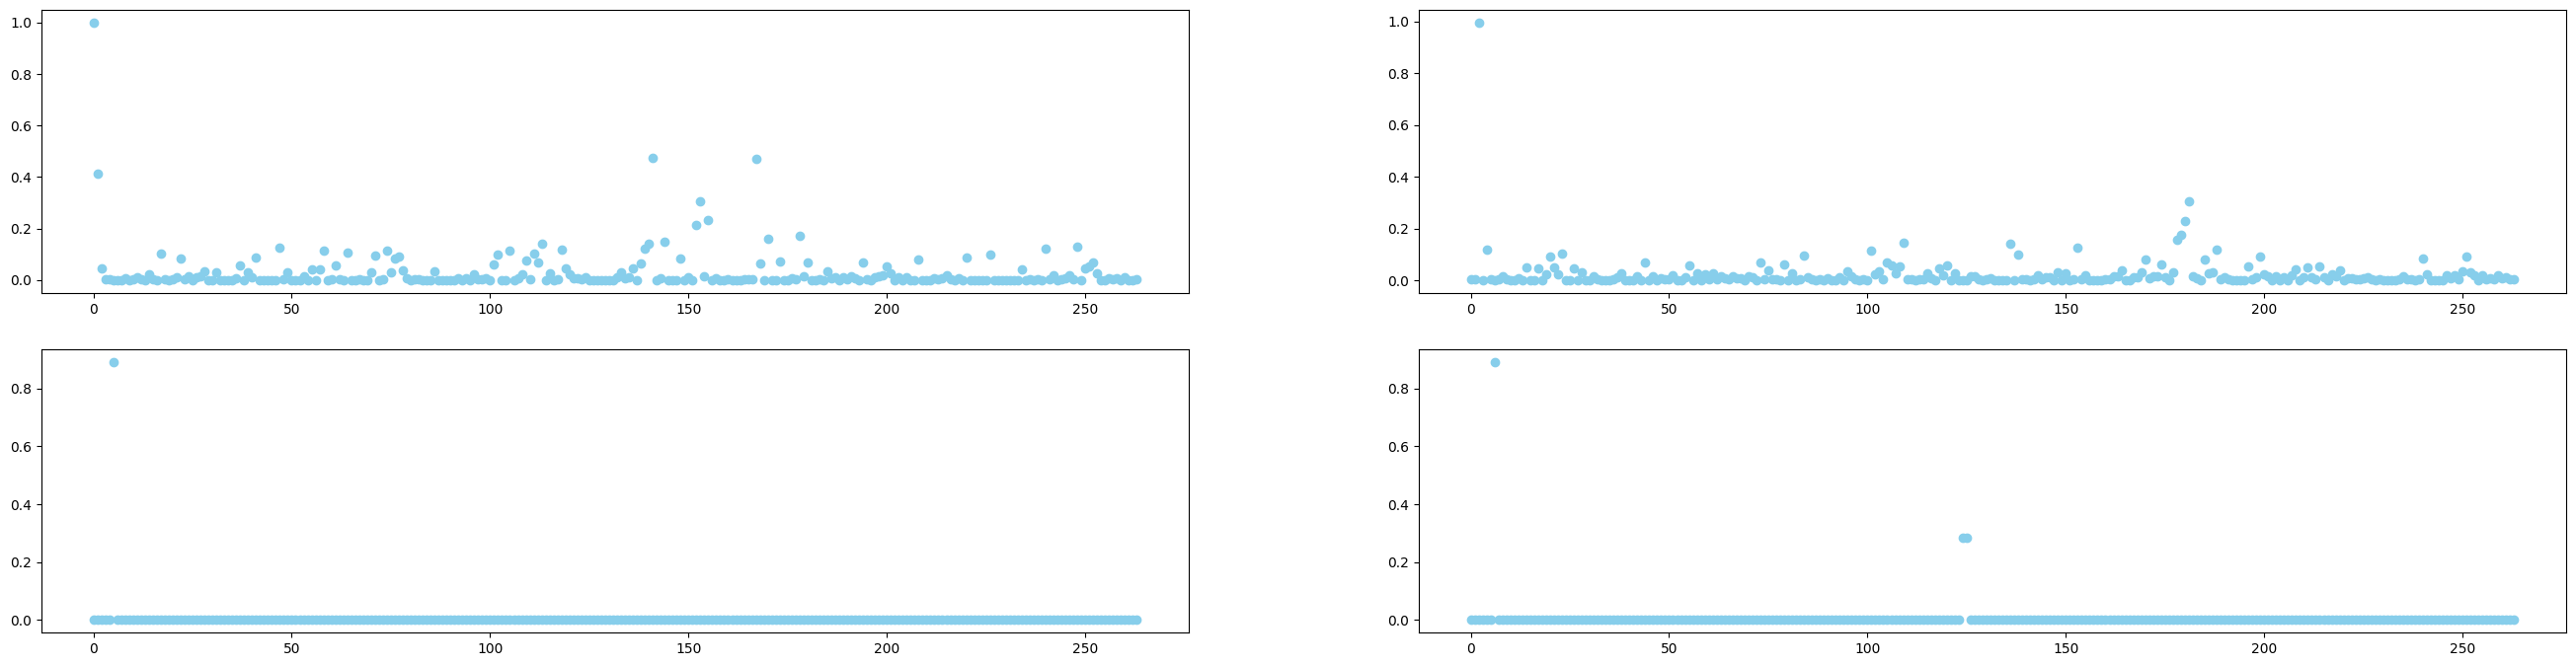

In [16]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(33, 8.2))  # 设置图形大小
fig1 = plt.subplot(2, 2, 1)
plt.scatter(range(264),  try_matrix[0].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig2 = plt.subplot(2, 2, 2)
plt.scatter(range(264),  try_matrix[1].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig3 = plt.subplot(2, 2, 3)
plt.scatter(range(264),  try_matrix[2].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

fig4 = plt.subplot(2, 2, 4)
plt.scatter(range(264),  try_matrix[3].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig5 = plt.subplot(2, 4, 5)
# plt.scatter(range(264),  try_matrix[4].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig6 = plt.subplot(2, 4, 6)
# plt.scatter(range(264),  try_matrix[5].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig7 = plt.subplot(2, 4, 7)
# plt.scatter(range(264),  try_matrix[6].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig8 = plt.subplot(2, 4, 8)
# plt.scatter(range(264),  try_matrix[7].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig9 = plt.subplot(2, 5, 9)
# plt.scatter(range(264),  try_matrix[8].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# fig10 = plt.subplot(2, 5, 10)
# plt.scatter(range(264),  try_matrix[9].mean(axis=2).mean(axis=0).reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色




# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [22]:
print(mask_list.shape)
cc = mask_list.mean(dim=2).mean(dim=0)
print(sum(cc > 0.1))

torch.Size([222, 264, 210])
tensor(2)


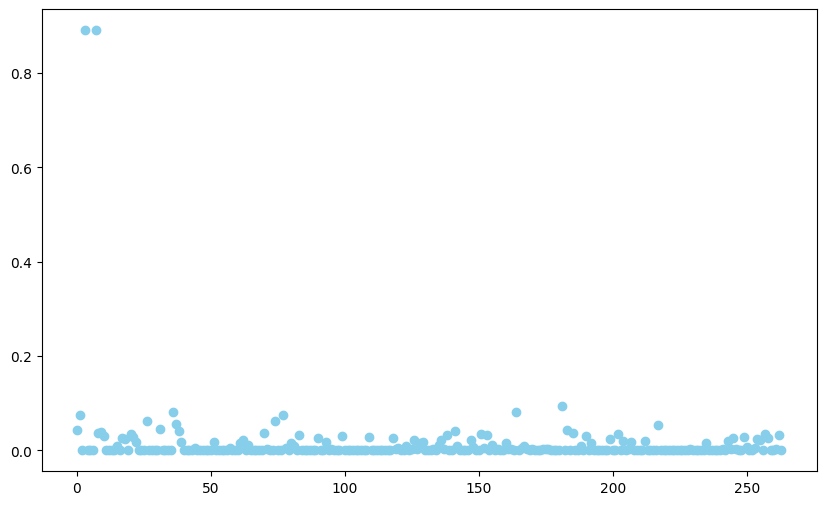

In [23]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  cc.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# 示例数据
categories = np.arange(1,265).reshape(1, 264) # X轴的分类标签
# values = [23, 45, 56, 78]  # 每个分类对应的值

# 创建柱状图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.scatter(range(264),  adj_gca.detach().numpy().reshape(264,), color='skyblue')  # 绘制柱状图，颜色设置为天蓝色

# 添加标题和标签
# plt.title('柱状图示例')  # 图形标题
# plt.xlabel('分类')  # X轴标签
# plt.ylabel('值')  # Y轴标签

# 显示图形
plt.show()

In [8]:
causality_matrix = []
for idx in range(264):
    read_file = 'encoder_emoid' + str(idx) + '.npy'
    read_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help1_7', read_file)
    mask = np.load(read_file)
    causality_matrix.append(mask)


print(len(causality_matrix))

264


In [10]:
causality_matrix1 = []
for idx in range(264):
    read_file = 'encoder_emoid' + str(idx) + '.npy'
    read_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/help4_7', read_file)
    mask = np.load(read_file)
    causality_matrix1.append(mask)


print(len(causality_matrix1))

264


In [11]:
cc = np.stack(causality_matrix, axis = 1)
dd = np.stack(causality_matrix1, axis = 1)
print(cc.shape)
print(dd.shape)
    

(222, 264, 264, 210)
(204, 264, 264, 210)


In [16]:
np.save('adj_emoid1.npy', cc)
np.save('adj_emoid4.npy', dd)

In [9]:
# adj1 = cc.mean(axis=3).mean(axis=0)
adj4 = dd.mean(axis=3).mean(axis=0)
# print(sum(sum(adj1 > 0.1)))
print(sum(sum(adj4 > 0.1)))
# print(23137/(264*264))
# print(15375/(264*264))

6492


In [ ]:
print(mask_list.shape)
print(causality_matrix[0].shape)

In [ ]:
merged_tensor = torch.cat(mask_list, dim=2)
print(merged_tensor.shape)

In [ ]:
aa = torch.FloatTensor(mask).mean(dim=2).mean(dim=0)
print(aa.shape)

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# from utils_bio import PCC, similarity_evaluate, directed_connection_analysis, roi2rsn, roi2rsn_weight

<Axes: >

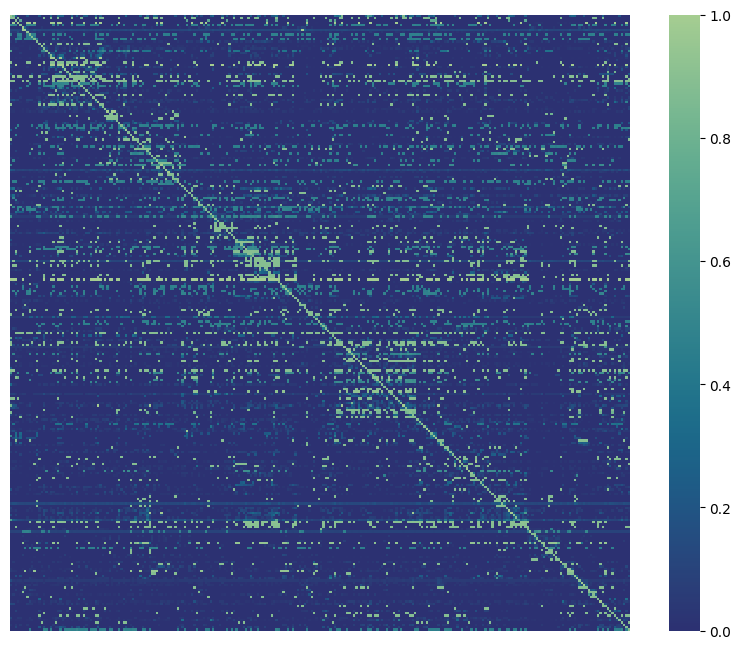

In [14]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(data=cc.mean(axis=3).mean(axis=0), cmap='crest_r', xticklabels=False, yticklabels=False)



<Axes: >

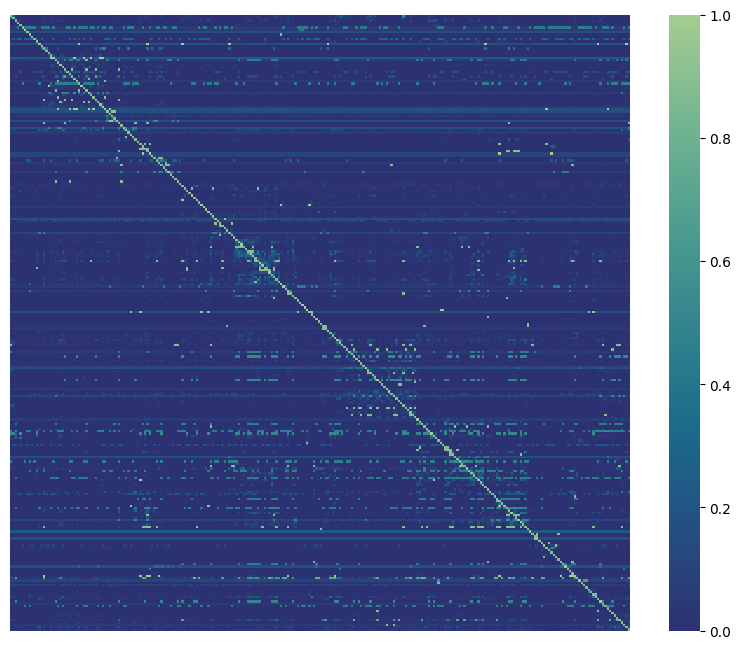

In [15]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(data=dd.mean(axis=3).mean(axis=0), cmap='crest_r', xticklabels=False, yticklabels=False)

<Axes: >

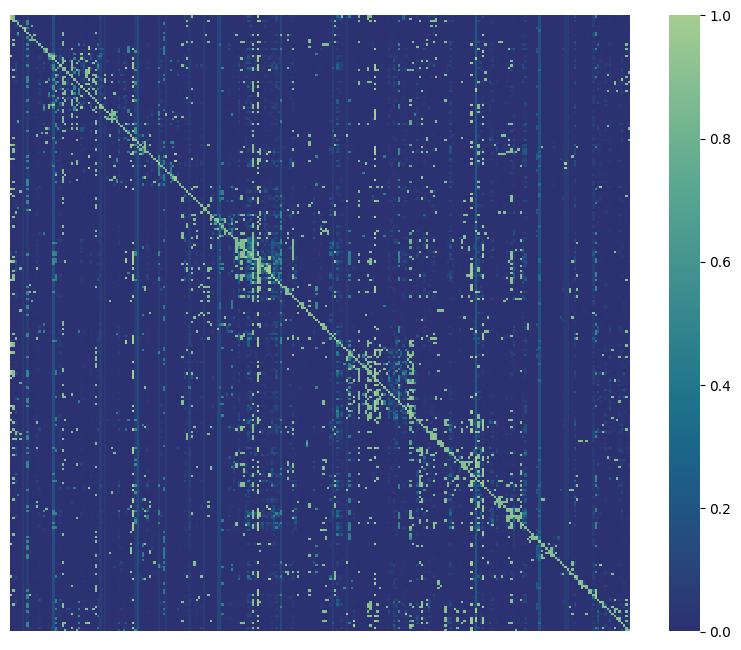

In [11]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(data=dd.mean(axis=3).mean(axis=0), cmap='crest_r', xticklabels=False, yticklabels=False)